In [1]:
%load_ext autoreload
%autoreload 2
#this will reload all changed modules every time before executing a new line

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nanofilm.ndimage import imread
import MyPacket.mypacket as mp

In [3]:
path_test_map = './data_demo/Flakesearch_Graphene_20180214175340935_087.png'

In [4]:
flake = mp.loadmap_astroclean(path_test_map)

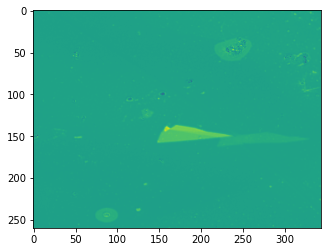

In [5]:
plt.imshow(flake, cmap='viridis');

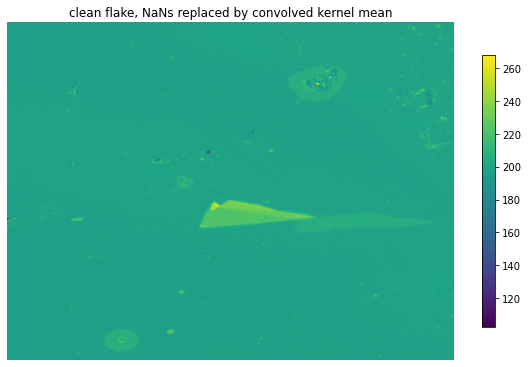

In [6]:
mp.plot_image_withCbar(flake, 'clean flake, NaNs replaced by convolved kernel mean');

In [7]:
flake.shape

(260, 344)

In [8]:
flakeReshaped = flake.reshape(flake.shape[0]*flake.shape[1], 1)

A single map is already a 2D array, but as it has only one channel (similar to a grayscale image), it needs to be reshaped to be a column, with the 1 as second parameter of the reshape.

In [19]:
flakeReshaped

array([[196.24716],
       [196.97797],
       [196.34993],
       ...,
       [197.04309],
       [196.5903 ],
       [196.33505]], dtype=float32)

In [9]:
from sklearn.cluster import KMeans

In [10]:
%%time
kmeans = KMeans(n_clusters=6, random_state=0).fit(flakeReshaped)
flakesegmented = kmeans.cluster_centers_[kmeans.labels_]


Wall time: 1.05 s


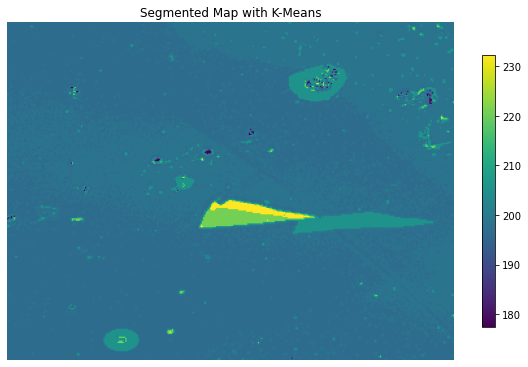

In [11]:
segmentedtoshow= flakesegmented.reshape(flake.shape[0], flake.shape[1])
mp.plot_image_withCbar(segmentedtoshow, 'Segmented Map with K-Means');

This seems to work fine :)

## Disadvantages and challenges:
   - application to a set of maps with dimension (rows, columns, [number of maps]
   - application to a set of combined delta and psi maps
   - the number of initial clusters must be set manually. Maybe this can be used as tunable parameter in the future front-end
   - loss of resolution on edges 

## To-Do:
   - ~~try Kmeans++~~ kmeans++ esta ya implementado dentro del kmeans normal
   - ~~try DBSCAN~~
   - ~~try segmentation by MeanShift~~ the result in the example looks awesome, but it can't be applied to our maps, since the imput image must be 
   - apply canny (or other method to detect edges in segmented image
   - try also other example maps
    

### Clustering with DBSCAN

In [14]:
from sklearn.cluster import DBSCAN

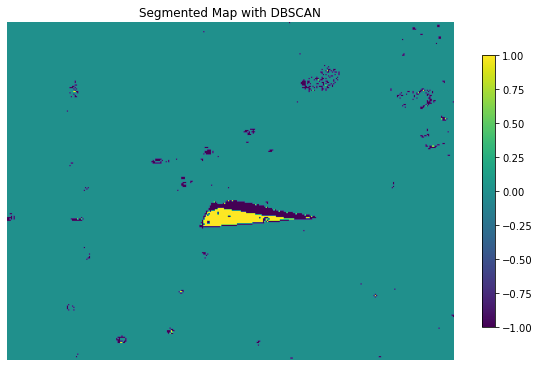

In [16]:
dbscan = DBSCAN(eps=0.5, min_samples=100).fit(flakeReshaped)
dbscansegmentedtoshow = (dbscan.labels_.reshape(flake.shape[0], flake.shape[1]))
mp.plot_image_withCbar(dbscansegmentedtoshow, 'Segmented Map with DBSCAN');

DBSCAN is much worse than K-Means for this task:
- We still have to tune 2 parameters: eps and min_samples
- It is way too slow (in the order of minutes) 
- The output needs to be converted to uint8 for it to be plotted in the right scale, for some reason
- On top of that the result of the segmentation is too bad. 

## Clustering with Meanshift

In [20]:
import cv2
from sklearn.cluster import MeanShift, estimate_bandwidth

In [ ]:
meanshift_segmented = cv2.pyrMeanShiftFiltering(flakeReshaped)